<a href="https://colab.research.google.com/github/clionelove123/Machine_Learning/blob/main/ML_Chap_10_Genetic_Algorithm_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# 코드 출처: https://github.com/Junst/TSP-Genetic-Algorithm/tree/master

import random
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
import time

In [36]:
MUTATION_RATE = 40
MUTATION_COUNT = 2
THRESHOLD = 35000
UNIFORMCROSSOVER_RATE = 0.5

csvfile = '/content/TSP.csv'

In [37]:
def read_csv(csvf): #csv 파일 읽기, csv file read
    City = np.genfromtxt(open(csvf, "rb"),dtype=float, delimiter=",", skip_header=0)
    print(City)
    return City

cityCoordinates = read_csv(csvfile)
citySize = len(read_csv(csvfile))


[[53.25009344 22.44488521]
 [21.57092818 17.44707561]
 [72.16107676 85.88179689]
 ...
 [ 6.28095388 87.71359465]
 [81.30504684 27.76985517]
 [45.90940209 22.3171196 ]]
[[53.25009344 22.44488521]
 [21.57092818 17.44707561]
 [72.16107676 85.88179689]
 ...
 [ 6.28095388 87.71359465]
 [81.30504684 27.76985517]
 [45.90940209 22.3171196 ]]


In [38]:
class Genome():
    chromosomes = []
    fitness = 100000

    def __init__(self, numberOfchromosomes=None):
        if numberOfchromosomes is not None:
            self.chromosomes = list(range(numberOfchromosomes))
            randShuffle(self.chromosomes)


In [39]:
def randShuffle(listToShuffle):
    return random.shuffle(listToShuffle)


In [40]:
def init_population(size) :
    initial_population = []
    for i in range(size):
        newGenome = Genome()
        newGenome.chromosomes = random.sample(range(1, citySize), citySize - 1)
        newGenome.chromosomes.insert(0, 0)
        newGenome.chromosomes.append(0)
        newGenome.fitness = Evaluate(newGenome.chromosomes)
        initial_population.append(newGenome)
    return initial_population

In [41]:
def Evaluate(chromosomes):
    Fitness = 0
    for i in range(len(chromosomes) - 1):
        p1 = cityCoordinates[chromosomes[i]]
        p2 = cityCoordinates[chromosomes[i + 1]]
        Fitness += Euclidean_distance(p1, p2)
    Fitness = np.round(Fitness, 2)
    return Fitness

In [42]:
def Euclidean_distance(x, y):
#    dist=np.sum(np.abs(np.array(x)-np.array(y)))
    dist = np.linalg.norm(np.array(x)-np.array(y))
    return dist

In [43]:
def findBestGenome(population):
    allFitness = [i.fitness for i in population]
    bestFitness = min(allFitness)
    return population[allFitness.index(bestFitness)]

In [44]:
def TournamentSelection(population, k):
    select = [population[random.randrange(0, len(population))] for i in range(k)]
    bestGenome = findBestGenome(select)
    return bestGenome

In [45]:
def Reproduction(population):
    parent1 = TournamentSelection(population, 15).chromosomes
    parent2 = TournamentSelection(population, 15).chromosomes
    while parent1 == parent2:
        parent2 = TournamentSelection(population, 15).chromosomes

    return OrderCrossover(parent1, parent2)

def randRange(first,last):
    return random.randint(first,last)


In [46]:
def OrderCrossover(parent1, parent2):
    child = Genome(None)
    child.chromosomes = []
    firstIndex = randRange(0,len(parent1)-1)
    secondIndex = randRange(firstIndex, len(parent1)-1)
    innerSet = parent1[firstIndex:secondIndex]
    startSet = []
    endSet = []
    for _, value in enumerate([item for item in parent2 if item not in innerSet]):
        if len(startSet)<firstIndex:
            startSet.append(value)
        else:
            endSet.append(value)
    child.chromosomes = startSet + innerSet + endSet

    if random.randrange(0, 100) < MUTATION_RATE:
        child.chromosomes = InversionMutation(child.chromosomes)

    child.fitness = Evaluate(child.chromosomes)
    return child


In [47]:
def InversionMutation(chromo) :
    for x in range(MUTATION_COUNT):
        p1, p2 = [random.randrange(1, len(chromo) - 1) for i in range(2)]
        while p1 == p2 or p1 > p2:
            p1 = random.randint(0, len(chromo) - 1)
            p2 = random.randint(0, len(chromo) - 1)
        log = chromo[p1:p2]
        log = log[::-1]
        chromo = chromo[:p1] + log +chromo[p2:]
    return chromo

In [48]:
def fitness_plot(generation, allBestFitness):
    plt.plot(range(0, generation), allBestFitness, c='blue')
    plt.xlabel('Generations')
    plt.ylabel('Best Fitness')
    plt.title('Fitness Function')
    plt.show()

In [49]:
def city_visualize(bestGenome, city):
    start = None
    for x, y in city:
        if start is None: #시작지점이면 표시
            start = city[0]
            plt.scatter(start[0], start[1], c="green", marker=">")
            plt.annotate("Start", (x + 2, y - 2), color='red')
        else: #시작지점 아니면
            plt.scatter(x, y, marker='.', s=10, c="black")

    #edge 표현을 위한 x, y 범위
    x_edge = [city[i][0] for i in bestGenome.chromosomes]
    y_edge = [city[i][1] for i in bestGenome.chromosomes]

    plt.plot(x_edge, y_edge, color="blue", linewidth=0.07, linestyle="-")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('City Edges')
    plt.show()

In [50]:
def GeneticAlgorithm(populationSize, Generation_Count):
    allBestFitness = []
    population = init_population(populationSize)
    generation = 0
    TotalBestFitness = 100000
    TotalBestPath = []

    averageFitness = round(np.sum([genom.fitness for genom in population]) / len(population), 2)
    bestGenome = findBestGenome(population)
    TotalBestFitness = bestGenome.fitness
    TotalBestPath = bestGenome.chromosomes
    print("Init_Condition\nPopulation Size: {1}\t Average Fitness: {2}\nBest Fitness: {3}".format(generation, len(population), averageFitness,bestGenome.fitness))
    print("Total Best Fitness : ",TotalBestFitness)
    print("Best Path:",TotalBestPath)
    allBestFitness.append(bestGenome.fitness)
    city_visualize(bestGenome, cityCoordinates)

    start = time.time()
    pre_turn=0;

    while generation < Generation_Count:
        generation += 1
        pre_turn += 1

        for i in range(populationSize):
            population.append(Reproduction(population))

        for genom in population:
            if genom.fitness > THRESHOLD:
                population.remove(genom)

        averageFitness = round(np.sum([genom.fitness for genom in population]) / len(population), 2)
        bestGenome = findBestGenome(population)
        end = time.time()

        if bestGenome.fitness < TotalBestFitness:
            TotalBestFitness = bestGenome.fitness
            TotalBestPath = bestGenome.chromosomes
            print("\n")
            print("Generation: {0}\nPopulation Size: {1}\t Average Fitness: {2}\nBest Fitness: {3}".format(generation, len(population), averageFitness,bestGenome.fitness))
            print("Total Best Fitness : ",TotalBestFitness)
            print("Total time : ", end-start) # 소요 시간 표기, Working Time
            print("Best Path:",TotalBestPath)
            allBestFitness.append(bestGenome.fitness)
            if 99.9  < pre_turn:
              city_visualize(bestGenome, cityCoordinates)
              pre_turn=0

    TotalBestFitness = bestGenome.fitness
    TotalBestPath = bestGenome.chromosomes
    print("\n")
    print("=========================================================================================================================")
    print("Final Result")
    print("Generation: {0}\nPopulation Size: {1}\t Average Fitness: {2}\nBest Fitness: {3}".format(generation, len(population), averageFitness,bestGenome.fitness))
    print("Total Best Fitness : ",TotalBestFitness)
    print("Total time : ", end-start) # 소요 시간 표기, Working Time
    print("Best Path:",TotalBestPath)
    allBestFitness.append(bestGenome.fitness)
    city_visualize(bestGenome, cityCoordinates)


    return bestGenome.chromosomes

Init_Condition
Population Size: 100	 Average Fitness: 52284.65
Best Fitness: 50906.94
Total Best Fitness :  50906.94
Best Path: [0, 738, 972, 455, 161, 931, 394, 903, 251, 338, 562, 852, 975, 711, 506, 629, 577, 276, 269, 457, 195, 44, 128, 516, 807, 690, 478, 785, 114, 351, 348, 54, 102, 11, 129, 699, 427, 832, 633, 966, 274, 779, 993, 35, 921, 281, 37, 185, 555, 697, 551, 915, 508, 648, 289, 334, 632, 12, 574, 387, 60, 605, 56, 310, 866, 329, 431, 578, 137, 316, 33, 838, 436, 223, 615, 800, 465, 803, 193, 559, 366, 717, 543, 610, 89, 861, 542, 988, 247, 372, 853, 293, 81, 147, 156, 936, 603, 989, 712, 260, 100, 930, 333, 273, 389, 196, 171, 186, 799, 441, 654, 726, 38, 891, 813, 29, 624, 456, 606, 440, 944, 804, 438, 447, 879, 135, 141, 279, 76, 821, 435, 91, 949, 876, 753, 691, 653, 826, 602, 228, 673, 533, 792, 399, 946, 45, 978, 614, 545, 17, 541, 849, 358, 371, 718, 917, 864, 163, 874, 327, 544, 956, 983, 426, 689, 401, 492, 57, 404, 585, 211, 750, 820, 720, 379, 627, 95, 277, 56

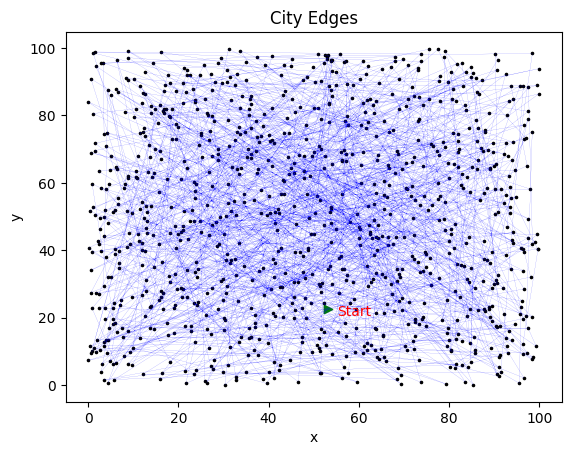



Generation: 1
Population Size: 100	 Average Fitness: 51700.62
Best Fitness: 49689.58
Total Best Fitness :  49689.58
Total time :  0.8469099998474121
Best Path: [0, 77, 447, 894, 655, 518, 234, 210, 428, 587, 48, 171, 68, 657, 863, 545, 421, 652, 397, 921, 468, 756, 786, 391, 667, 368, 706, 262, 338, 743, 435, 647, 354, 941, 442, 813, 598, 665, 817, 642, 261, 168, 973, 997, 408, 74, 533, 11, 461, 317, 482, 24, 597, 940, 619, 185, 449, 361, 151, 53, 489, 372, 90, 305, 413, 581, 790, 101, 753, 714, 20, 250, 238, 478, 961, 864, 63, 858, 240, 142, 73, 360, 918, 799, 822, 208, 172, 885, 546, 591, 739, 349, 195, 117, 239, 909, 472, 508, 862, 888, 136, 9, 601, 540, 315, 443, 22, 627, 534, 956, 125, 233, 307, 1, 681, 75, 296, 959, 855, 984, 187, 243, 682, 763, 292, 539, 531, 554, 342, 782, 523, 854, 158, 912, 60, 879, 103, 911, 964, 570, 924, 683, 309, 13, 245, 698, 645, 337, 403, 952, 8, 263, 830, 270, 933, 466, 378, 600, 374, 905, 532, 607, 700, 740, 217, 851, 175, 118, 418, 783, 646, 132, 

In [ ]:
solution=GeneticAlgorithm(populationSize=100, Generation_Count=100000) #Population size, Generation Count 입력